In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization

import plotly.offline as py
import plotly.graph_objs as go

import keras_tuner as kt
import tensorflow as tf
import datetime, time
from tensorflow import keras
import tensorflow as tf
import random
from keras import backend as K
from keras.regularizers import L1L2

In [2]:
tf.device('/device:GPU:0')

In [3]:
df = pd.read_csv("../data/gold_price_data.csv")

df.head()

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4


In [4]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df

,Date,Value
0,1970-01-01,35.20
1,1970-04-01,35.10
2,1970-07-01,35.40
3,1970-10-01,36.20
4,1971-01-01,37.40
...,...,...
10782,2020-03-09,1672.50
10783,2020-03-10,1655.70
10784,2020-03-11,1653.75
10785,2020-03-12,1570.70


In [5]:
days_to_predict = 500

df_train = df['Value'][:len(df['Value'])-days_to_predict].values.reshape(-1,1)
df_test  = df['Value'][len(df['Value'])-days_to_predict:].values.reshape(-1,1)

scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [6]:
def create_dataset(dataset, back_values=30):
    """
    Cria conjuntos de dados para treinamento de modelos de séries temporais.

    Args:
        dataset (numpy.ndarray): O conjunto de dados de séries temporais.
        back_values (int, optional): O número de valores anteriores na série a serem usados como entrada. O valor padrão é 30.

    Returns:
        numpy.ndarray, numpy.ndarray: Um par de arrays numpy contendo as sequências de entrada (X) e os rótulos correspondentes (Y).
    """
    X, y = [], []

    for i in range(len(dataset) - back_values):

        # Cria sequências de entrada
        X.append(dataset[i:(i + back_values), 0])

        # Cria os rótulos correspondentes
        y.append(dataset[i + back_values, 0])

    return np.array(X), np.array(y)

x_train, y_train = create_dataset(scaled_train)
x_test, y_test = create_dataset(scaled_test)

In [7]:
x_train.shape

(10257, 30)

In [8]:
x_test.shape

(470, 30)

In [9]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

### Definindo o Modelo (LSTM)

In [10]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    
def model_builder(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit', min_value=32, max_value=512, step=32), return_sequences=True, input_shape= (x_train.shape[1], x_train.shape[2]), bias_regularizer = L1L2(0.009, 0.004)))
    
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.05)))
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
   
    model.compile(loss=root_mean_squared_error, optimizer='adam', metrics = ['mse'])
    
    return model

tuner = kt.RandomSearch(model_builder, objective='val_loss', max_trials = 2, executions_per_trial =1, directory = "./gold1/")

callbacks = [keras.callbacks.EarlyStopping(monitor= 'val_loss', # Monitor the validation loss
                                                     min_delta=0,    # until it doesn't change (or gets worse)
                                                     patience=5,  # patience > 1 so it continutes if it is not consistently improving
                                                     verbose=0, 
                                                     mode='auto')]

tuner.search(x=x_train, y=y_train, epochs = 1, batch_size =512, validation_data=(x_test, y_test), callbacks=[callbacks],shuffle = True)

Trial 2 Complete [00h 00m 08s]
val_loss: 4.331597328186035

Best val_loss So Far: 2.3060388565063477
Total elapsed time: 00h 00m 20s
INFO:tensorflow:Oracle triggered exit


In [11]:
tuner.results_summary()

Results summary
Results in ./gold1/untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
input_unit: 160
n_layers: 4
lstm_0_units: 448
Dropout_rate: 0.4
dense_activation: sigmoid
lstm_1_units: 32
lstm_2_units: 32
lstm_3_units: 32
Score: 2.3060388565063477

Trial 1 summary
Hyperparameters:
input_unit: 320
n_layers: 2
lstm_0_units: 128
Dropout_rate: 0.05
dense_activation: sigmoid
lstm_1_units: 480
lstm_2_units: 64
lstm_3_units: 512
Score: 4.331597328186035


In [12]:
best_model = tuner.get_best_models(num_models=1)[0]

In [13]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 160)            122240    
                                                                 
 lstm_1 (LSTM)               (None, 1, 448)            1091328   
                                                                 
 lstm_2 (LSTM)               (None, 1, 32)             61568     
                                                                 
 lstm_3 (LSTM)               (None, 1, 32)             8320      
                                                                 
 lstm_4 (LSTM)               (None, 1, 32)             8320      
                                                                 
 dropout (Dropout)           (None, 1, 32)             0         
                                                                 
 dense (Dense)               (None, 1, 1)              3

In [14]:
history = best_model.fit(x=x_train, y=y_train, epochs=2, batch_size=128, validation_data=(x_test, y_test), shuffle=False, verbose=0)

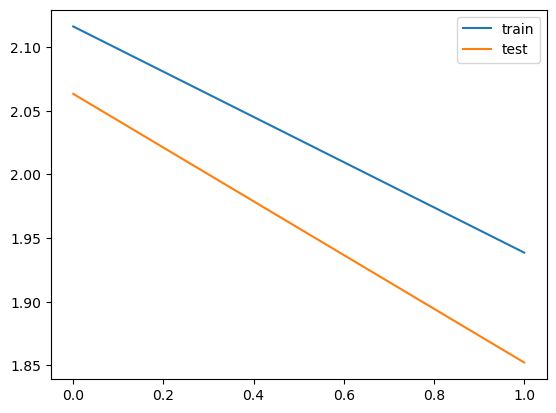

In [15]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [16]:
predicted_gold_price = best_model.predict(x_test)

15/15 [==============================] - 1s 6ms/step


In [17]:
predicted_gold_price = scaler_test.inverse_transform(predicted_gold_price.reshape(-1, 1))

In [18]:
true = scaler_test.inverse_transform(y_test.reshape(-1, 1))

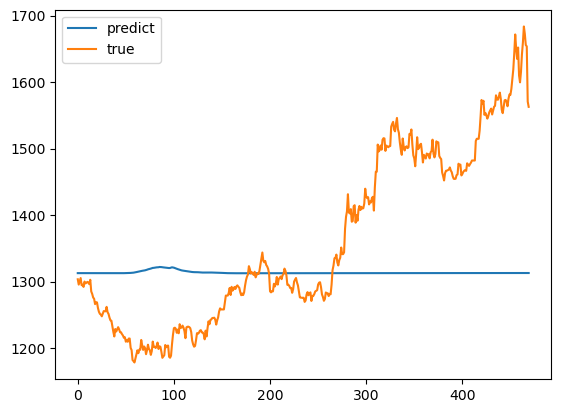

In [19]:
plt.plot(predicted_gold_price, label='predict')
plt.plot(true, label='true')
plt.legend()
plt.show()